In [1]:
import pandas as pd
import numpy as np
import math
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
import matplotlib.pyplot as plt
import subprocess

In [ ]:
subprocess.Popen("src.create_ufc_data", cwd="/Users/justinmilner/Desktop/UFC-Predictions-master")

# %run '../../src/create_ufc_data.py' #creates total_fight_data.csv, fighter_details.csv

# Preprocessing

Before this, add the upcoming fights to total_fight_data

In [3]:
%run 'preprocessing_and_EDA-1.py' #reads total_fight_data.csv, fighter_details.csv, creates infdata.csv

Index(['R_fighter', 'B_fighter', 'Fight_type', 'R_KD', 'B_KD', 'R_SIG_STR.',
       'B_SIG_STR.', 'R_SIG_STR_pct', 'B_SIG_STR_pct', 'R_TOTAL_STR.',
       'B_TOTAL_STR.', 'R_TD', 'B_TD', 'R_TD_pct', 'B_TD_pct', 'R_SUB_ATT',
       'B_SUB_ATT', 'R_REV', 'B_REV', 'R_CTRL', 'B_CTRL', 'R_HEAD', 'B_HEAD',
       'R_BODY', 'B_BODY', 'R_LEG', 'B_LEG', 'R_DISTANCE', 'B_DISTANCE',
       'R_CLINCH', 'B_CLINCH', 'R_GROUND', 'B_GROUND', 'win_by', 'last_round',
       'last_round_time', 'Format', 'Referee', 'date', 'location', 'Winner'],
      dtype='object')
0         2 of 3
1         6 of 7
2         4 of 8
3         1 of 1
4       14 of 21
          ...   
6054      1 of 1
6055      0 of 0
6056      1 of 1
6057      1 of 1
6058      0 of 0
Name: R_BODY, Length: 6059, dtype: object
NaN values in Referee = 32
NaN values in Winner = 110
Number of NaN in fighter_name : 0
Number of NaN in Height : 0
Number of NaN in Weight : 0
Number of NaN in Reach : 0
Number of NaN in Stance : 0
Number of NaN in D

KeyError: "None of ['index'] are in the columns"

Nan in Referee: 32
Nan in Winner: 24
Nan in B_avg_KD: 1430
Nan in B_avg_opp_KD: 1430
Nan in B_avg_SIG_STR_pct: 1430
Nan in B_avg_opp_SIG_STR_pct: 1430
Nan in B_avg_TD_pct: 1430
Nan in B_avg_opp_TD_pct: 1430
Nan in B_avg_SUB_ATT: 1430
Nan in B_avg_opp_SUB_ATT: 1430
Nan in B_avg_REV: 1430
Nan in B_avg_opp_REV: 1430
Nan in B_avg_SIG_STR_att: 1430
Nan in B_avg_SIG_STR_landed: 1430
Nan in B_avg_opp_SIG_STR_att: 1430
Nan in B_avg_opp_SIG_STR_landed: 1430
Nan in B_avg_TOTAL_STR_att: 1430
Nan in B_avg_TOTAL_STR_landed: 1430
Nan in B_avg_opp_TOTAL_STR_att: 1430
Nan in B_avg_opp_TOTAL_STR_landed: 1430
Nan in B_avg_TD_att: 1430
Nan in B_avg_TD_landed: 1430
Nan in B_avg_opp_TD_att: 1430
Nan in B_avg_opp_TD_landed: 1430
Nan in B_avg_HEAD_att: 1430
Nan in B_avg_HEAD_landed: 1430
Nan in B_avg_opp_HEAD_att: 1430
Nan in B_avg_opp_HEAD_landed: 1430
Nan in B_avg_BODY_att: 1430
Nan in B_avg_BODY_landed: 1430
Nan in B_avg_opp_BODY_att: 1430
Nan in B_avg_opp_BODY_landed: 1430
Nan in B_avg_LEG_att: 1430
Nan 

/Users/justinmilner/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Nan in Winner: 24
Nan in B_index_y: 6059
Nan in B_Height_cms: 6059
Nan in B_Reach_cms: 6059
Nan in B_Weight_lbs: 6059
Nan in R_index_y: 6059
Nan in R_Height_cms: 6059
Nan in R_Reach_cms: 6059
Nan in R_Weight_lbs: 6059


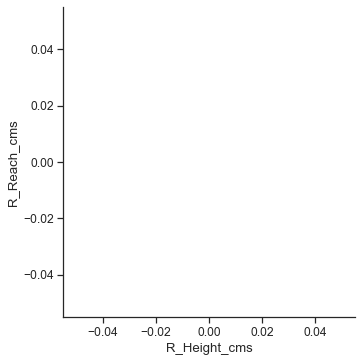

In [4]:
%run 'preprocessing_and_EDA-2.py' #reads infdata.csv, creates infdata_stage1.csv

In [11]:
%run 'JMFeatureSelection.py' #reads infdata_stage1.csv, creates infdata_stage2.csv

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
%run 'JMPreprocessingDeleteRowNulls.py' #reads infdata_stage2.csv, creates infdata_stage3.csv

# Building the classifier

### Training

In [ ]:
df = pd.read_csv('../../data/infdata_stage3.csv')

In [ ]:
df.drop(columns=['R_DOB','B_DOB'], inplace=True)

In [ ]:
numberOfFights = 10
inf_df = df.head(numberOfFights)
inf_df.drop(columns = ['Winner'], inplace=True)
df = df.iloc[numberOfFights:]

In [ ]:
#splitting up data into training/testing
y = df['Winner']
X = df.drop(columns = 'Winner')

X, X_test, y, y_test = train_test_split(X, y, test_size=0.05, random_state=43)

In [ ]:
# define the model with default hyperparameters
model = AdaBoostClassifier()
# define the grid of values to search
grid = dict()
grid['n_estimators'] = [500]
grid['learning_rate'] = [0.01, 0.1]

In [ ]:
# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=8, n_repeats=3, random_state=1)
# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc')
# execute the grid search
grid_result = grid_search.fit(X, y)

In [ ]:
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [ ]:
# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
model = AdaBoostClassifier(n_estimators=500, learning_rate=.1)
model.fit(X, y)

In [ ]:
#getting test results
y_pred=model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
model.score(X_test, y_test)

# Exploring the relation between the algorithm's confidence and accuracy

In [ ]:
#creating a list of correct/incorrect
correctOrNot = [] #0 is correct, 1 is not
for prediction, truth in zip(y_pred, y_test):
    if prediction != truth:
        correctOrNot.append(1)
    else:
        correctOrNot.append(0)


In [ ]:
#creating a list of correct/incorrect and confidence
Probabilities = model.predict_proba(X_test)
RelativeConfidence = []
for row in range(len(Probabilities)):
    RelativeConfidence.append(abs(Probabilities[row][0] - Probabilities[row][1]))
from statistics import mean  
plt.hist(RelativeConfidence, bins=60)

In [ ]:
#plt.plot(RelativeConfidence,correctOrNot)
plt.figure(figsize=(20,5))
plt.xlim([0.0, .05])
plt.scatter(RelativeConfidence, np.zeros_like(RelativeConfidence) + 0. , c=correctOrNot)


In [ ]:
confidenceOfCorrect = []
confidenceOfIncorrect = []
for index in range(len(correctOrNot)):
    if correctOrNot[index] == 0:
        confidenceOfCorrect.append(RelativeConfidence[index])
    else:
        confidenceOfIncorrect.append(RelativeConfidence[index])

In [ ]:
#bar graph displaying the percent correct within each bin

correcthist, bins = np.histogram(confidenceOfCorrect, bins=60)
incorrecthist, bins = np.histogram(confidenceOfIncorrect, bins=bins)
percentCorrectHist = []
for index in range(len(correcthist)):
    #print(incorrecthist)
    if (correcthist[index] + incorrecthist[index]) == 0:
        percentCorrectHist.append(0)
    else:
        percentCorrectHist.append(correcthist[index] / (correcthist[index] + incorrecthist[index]))


width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, percentCorrectHist, align='center', width=width)
plt.figure(figsize=(30,5))
plt.show()

#here, the ideal threshold seems to be around .0135 

In [ ]:
model.predict(inf_df)

In [ ]:
#Blue is 1, Red is 0
Probabilities = model.predict_proba(inf_df)
Probabilities

In [ ]:
RelativeConfidence = []
for row in range(len(Probabilities)):
    RelativeConfidence.append(abs(Probabilities[row][0] - Probabilities[row][1]))
    
RelativeConfidence


### Today, March 27 2021 I'm choosing a threshold of .0135.
#### This means that no bets are to be made